In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

In [79]:
plt.rcParams["figure.figsize"] = (15,8)

# Finding the right ingredients to provide

## 1) A fist look inside the possible food

The following dataframe we obtained has nutritional information about the most varied food products there are. The information we are most interested in for our analysis. per product, are:
* **Food Group** - a generalized group in which the product is inserted
* **Food Name** - the name of the product itself
* **Protein (g)** - The amount of grams of proteins in a 100g serving
* **Carbohydrates (g)** - The amount of grams of carbohydrates in a 100g serving
* **Fat (g)** - The amount of grams of fat in a 100g serving

In [80]:
#load dataset USDA-Food
usda_foods = pd.read_excel("data/raw/USDA-Food.xlsx", sheet_name=0)
food_properties = pd.DataFrame(usda_foods[['Food Group', 'Food Name', 'Protein (g)', 'Carbohydrates (g)', 'Fat (g)']])
food_properties.head()

,Food Group,Food Name,Protein (g),Carbohydrates (g),Fat (g)
0,Dairy and Egg Products,"Butter, salted",0.85,0.06,81.11
1,Dairy and Egg Products,"Butter, whipped, with salt",0.49,2.87,78.30
2,Dairy and Egg Products,"Butter oil, anhydrous",0.28,0.00,99.48
3,Dairy and Egg Products,"Cheese, blue",21.40,2.34,28.74
4,Dairy and Egg Products,"Cheese, brick",23.24,2.79,29.68


In [81]:
#checking size of the database
food_properties.index.size

6347

There are a lot of possible product inside this database, but many of them could be unsuitable for our purpose. As for first task, we check the available _'**Food Group'**_ and remove the ones we won't need.  
We plot them for a clear understanding

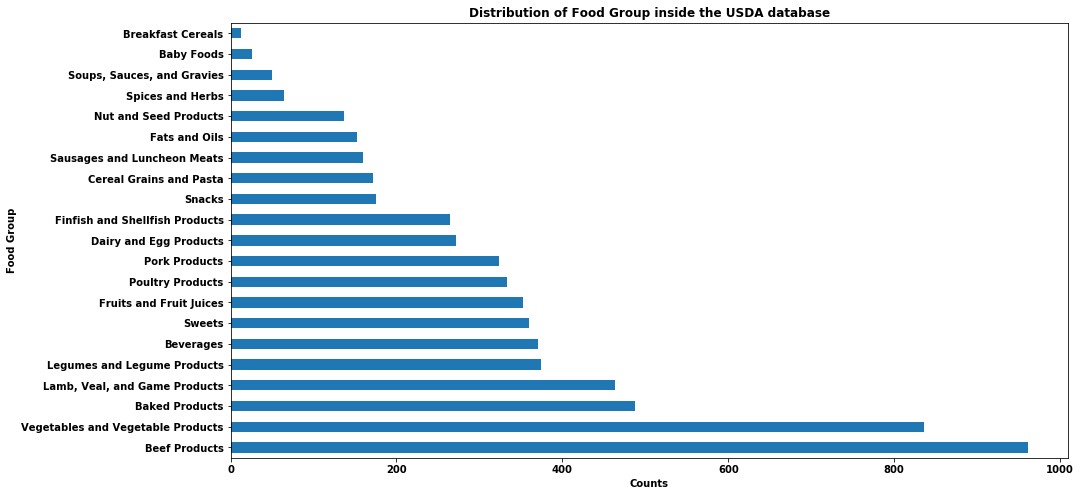

In [82]:
food_properties["Food Group"].value_counts().plot(kind="barh")
plt.title("Distribution of Food Group inside the USDA database")
plt.xlabel("Counts")
plt.ylabel("Food Group");

As expected, **not all most poossible products are necessarily healthy. Also, other are not suitable for our purpose** (like, as example *"Baby Food"*). Therefore, we will no longer consider the following items:
- Sweets
- Beverages
- Snacks 
- Baked Products
- Spices and Herbs  
- Nut and Seed Products
- Dairy and Egg Products
- Breakfast Cereals
- Baby Foods
- Soups, Sauces, and Gravies
- Spices and Herbs
- Nut and Seed Products
- Fats and Oils

In [83]:
not_suit = ["Sweets","Snacks","Beverages", "Baked Products","Spices and Herbs", "Nut and Seed Products", \
            "Dairy and Egg Products", "Breakfast Cereals", "Baby Foods", "Soups, Sauces, and Gravies", \
           "Spices and Herbs", "Nut and Seed Products", "Fats and Oils"]
food_properties = food_properties[~food_properties["Food Group"].isin(not_suit)].reset_index(drop=True)
food_properties.head()

,Food Group,Food Name,Protein (g),Carbohydrates (g),Fat (g)
0,Poultry Products,"Chicken, broiler, rotisserie, BBQ, breast meat...",28.04,0.00,3.57
1,Poultry Products,"Chicken, broilers or fryers, meat and skin and...",18.33,0.13,14.83
2,Poultry Products,"Chicken, broilers or fryers, meat and skin and...",22.84,9.03,17.53
3,Poultry Products,"Chicken, broilers or fryers, meat and skin and...",28.57,3.27,15.27
4,Poultry Products,"Chicken, broilers or fryers, meat and skin and...",26.78,0.06,13.27


New check on dimension:

In [84]:
food_properties.index.size

4240

By a first look to the head of the dataset we also understand that the `USDA-Food` contains many processed product. As we are interested in *raw* products for our analysis, we filter only this one:

In [85]:
food_properties = food_properties[food_properties["Food Name"].str.contains("raw")]
food_properties.index.size

1283

We have a set of **1283** products from which choose the possible diet.  
We keep this dataset as it is for now and we move to the next part.

## 2) Consider the producer prices
An important ax in our next choose of products will be **the cost of producing the products** inside the European countries. For this reason, we introduce now **two new datasets** and we use them to filter more the `USDA-Food` ones.  
The new dataset are:
- [EU_prices_for_representative](https://ec.europa.eu/info/food-farming-fisheries/farming/facts-and-figures/markets/prices/price-monitoring-sector/eu-prices-selected-representative-products_en) by the European Commission
- [FAO Producer prices](http://www.fao.org/faostat/en/#data/PP) (in particular we use the data for cereal and vegetables prices) 

We use the two of them because just FAO one seems not to be complete for our purpose.  
*Note*: FAO data are from 2018, while EU_prices will go from 2014 to 2019. We assume this prices to be ok even if they are from different period because there are no available data online.

In [86]:
# loading the new datasets
eu_prices = pd.read_csv("data/raw/europe_food_prices.csv", usecols=["Category", "Product desc", "Unit", "Country", "Period", "MP Market Price"])\
            .rename(columns={"Product desc": "Product", "MP Market Price":"Price"})
eu_prices.head(1)

,Category,Product,Unit,Country,Period,Price
0,Animal Products,Chicken,€/100 kg carcass weight,AT,201910,268.11


In order to have reasonable prices, we consider only the last five years, from 2014 to october 2019:

In [87]:
eu_prices = eu_prices[eu_prices.Period.between(201400, 201910)]

Check the availability inside this dataset:

In [88]:
eu_prices.Product.unique()

array(['Chicken', 'Raw Milk', 'SMP', 'WMP', 'Whey Powder', 'Butter',
       'Butter Oil', 'Emmental', 'Cheddar', 'Edam', 'Gouda', 'Apricots',
       'Avocados', 'Cherries', 'Lemons', 'Clementines', 'Strawberries',
       'Kiwis', 'Mandarins', 'Melons', 'Nectarines', 'Oranges',
       'Watermelons', 'Peaches', 'Pears', 'Apples Braeburn',
       'Apples Boskoop', 'Apples Cox', 'Apples Elstar', 'Apples Fuji',
       'Apples Gala', 'Apples Golden', 'Apples Granny', 'Apples Idared',
       'Apples Jonagold', 'Apples Red', 'Apples Shampion', 'Plums',
       'Grapes', 'Satsumas', 'Garlic', 'Asparagus', 'Eggplants',
       'Cabbages', 'Carrots', 'Mushrooms', 'Cauliflowers', 'Cucumbers',
       'Courgettes', 'Beans', 'Lettuces', 'Leeks', 'Onions', 'Peppers',
       'Tomatoes Cherry', 'Tomatoes Trusses', 'Tomatoes Round',
       'Feed Oats', 'Milling Oats', 'Feed Wheat', 'Bread Wheat',
       'Durum Wheat', 'Feed Maize', 'Malting Barley', 'Feed Barley',
       'Feed Rye', 'Bread Rye', 'Lampante 

There is a good number of representatives from all the categories we have in the `USDA-Food`, but we miss an important source of carbohydrates: rice. Also, there is no meat present in the database.  
For this reason, we go to scrape these information from FAO:

In [89]:
fao_prices = pd.read_csv("data/raw/fao_cereal_meat_prices.csv", usecols=["Area", "Item", "Value"])
fao_prices

,Area,Item,Value
0,Albania,Barley,302.2
1,Albania,Maize,300.3
2,Albania,"Meat, cattle",6735.7
3,Albania,"Meat, chicken",3773.1
4,Albania,"Meat, pig",4890.6
...,...,...,...
665,Zambia,"Meat, goat",3189.9
666,Zambia,"Meat, pig",4023.7
667,Zambia,Millet,520.9
668,Zambia,"Rice, paddy",1352.5


*Note*: FAO data are in USD/tonne  

At this point we need to restrict our product analysis. In **_Which European countries can help Africa?_** section we defined which are the countries with the highest surplus in Europe, that can be able to help Africa only by giving away a small fraction of their surplus.  
From the previous classification we remove now the *Russian Federation*, because has an huge surplus and alone able to resolve the African problem (and we want a fair share between the richest European countries), together with *Poland, Ukraine* and *Romania*, because small nations.  
At this point we have build the set of **top 5 countries that will help Africa: France, Italy, United Kingdom, Germany** and **Spain**.

In [90]:
# defining countries
best_countries = ["France", "Italy", "United Kingdom", "Germany", "Spain"]
best_countries_code = ["FR", "IT", "UK", "DE", "ES"] # codes for the eu_prices

# filtering our datasets
eu_prices = eu_prices[eu_prices.Country.isin(best_countries_code)]
fao_prices = fao_prices[fao_prices.Area.isin(best_countries)]

Let's take a look to the products in the FAO **ceral** dataset now

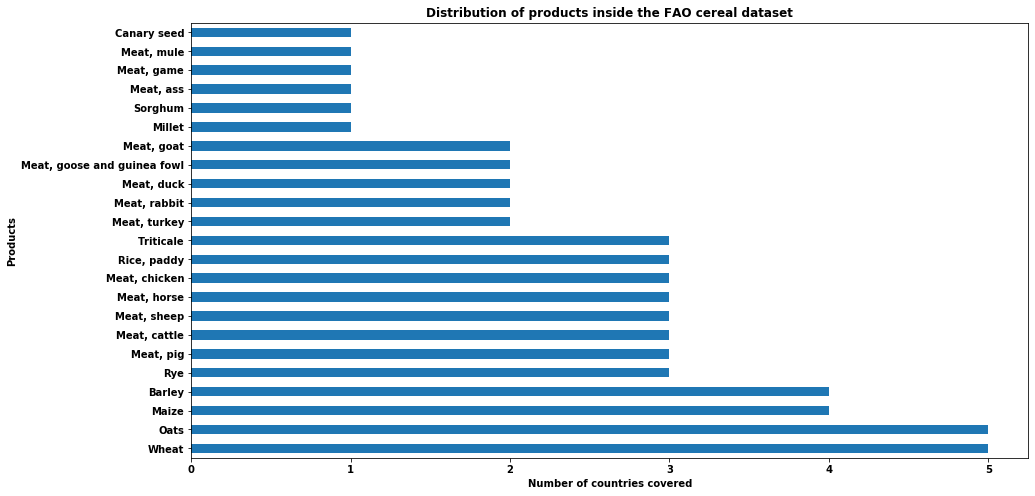

In [91]:
fao_prices.Item.value_counts().plot(kind="barh")
plt.title("Distribution of products inside the FAO cereal dataset")
plt.xlabel("Number of countries covered")
plt.ylabel("Products");

Two fundamental problems emerge here: we don't have the price for rice and meat in all the interested countries, **we need to impute them**  
We start from the rice.  
In order to do so, what we do now is try to find a correlation between the product we have in **all the countries** (*Wheat* and *Oats*) and the rice

In [92]:
rice_df = fao_prices[fao_prices.Item=="Rice, paddy"]
rice_df = rice_df.merge(fao_prices, on="Area")
rice_df = rice_df[rice_df.Item_y.str.contains("Wheat|Oats")]
rice_df["Coeff"] = rice_df.Value_x/rice_df.Value_y
rice_df.sort_values("Item_y")

,Area,Item_x,Value_x,Item_y,Value_y,Coeff
11,France,"Rice, paddy",372.0,Oats,145.7,2.553191
17,Italy,"Rice, paddy",403.7,Oats,272.3,1.482556
33,Spain,"Rice, paddy",344.6,Oats,171.3,2.011675
15,France,"Rice, paddy",372.0,Wheat,195.0,1.907692
19,Italy,"Rice, paddy",403.7,Wheat,233.9,1.725951
38,Spain,"Rice, paddy",344.6,Wheat,217.3,1.585826


In [93]:
mean_coeff_oats = rice_df[rice_df["Item_y"] == "Oats"].Coeff.mean()
mean_coeff_wheat = rice_df[rice_df["Item_y"] == "Wheat"].Coeff.mean()
print("The mean coefficient for oats is", mean_coeff_oats)
print("The mean coefficient for wheat is", mean_coeff_wheat)

The mean coefficient for oats is 2.0158076390008994
The mean coefficient for wheat is 1.7398232052849225


As the wheat seems the one with less fluctuation, we take this one for our imputation.

In [94]:
wheat_germany = fao_prices[(fao_prices.Area == "Germany") & (fao_prices.Item=="Wheat")].Value.values[0]
row_germ = pd.DataFrame(np.array([["Germany", "Rice, paddy", '%.1f'%(mean_coeff_wheat*wheat_germany)]]), columns=["Area", "Item", "Value"])
wheat_uk = fao_prices[(fao_prices.Area == "United Kingdom") & (fao_prices.Item=="Wheat")].Value.values[0]
row_uk = pd.DataFrame(np.array([["United Kingdom", "Rice, paddy", '%.1f'%(mean_coeff_wheat*wheat_uk)]]), columns=["Area", "Item", "Value"])
fao_prices = fao_prices.append(row_germ)
fao_prices = fao_prices.append(row_uk).reset_index(drop=True)

In [95]:
fao_prices[fao_prices.Item=="Barley"]

,Area,Item,Value
0,France,Barley,195.1
16,Germany,Barley,195.4
36,Spain,Barley,203.7
55,United Kingdom,Barley,197.4


For the meat case, we first look to the countries for which we have data (considering the most general case: cattle, that we consider cow meat)

In [96]:
fao_prices[fao_prices.Item=="Meat, cattle"]

,Area,Item,Value
2,France,"Meat, cattle",4549.5
18,Germany,"Meat, cattle",4033.1
40,Spain,"Meat, cattle",2774.8


We need to impute the prices for Italy and United Kingdom:
- For Italy we can look [here](https://www.bordbia.ie/farmers-growers/farmers/prices-markets/eu-world-cattle-prices/?country=Italy). Taking a price average we have a price of 3.42€/kg
- For UK, [here](https://www.bordbia.ie/farmers-growers/farmers/prices-markets/eu-world-cattle-prices/?country=Gt.%20Britain). Taking the average we have 3.71€/kg

We need to multiply these prices by **1.10** (actual change EUR/USD) and 1000 (to consider tonnes)

In [97]:
meat_italy = pd.DataFrame(np.array([["Italy", "Meat, cattle", '%.1f'%(3.42*1.10*1000)]]), columns=["Area", "Item", "Value"])
meat_uk = pd.DataFrame(np.array([["United Kingdom", "Meat, cattle", '%.1f'%(3.71*1.10*1000)]]), columns=["Area", "Item", "Value"])
fao_prices = fao_prices.append(meat_italy)
fao_prices = fao_prices.append(meat_uk).reset_index(drop=True)

Reprint the plot to see the final product in the FAO dataset:

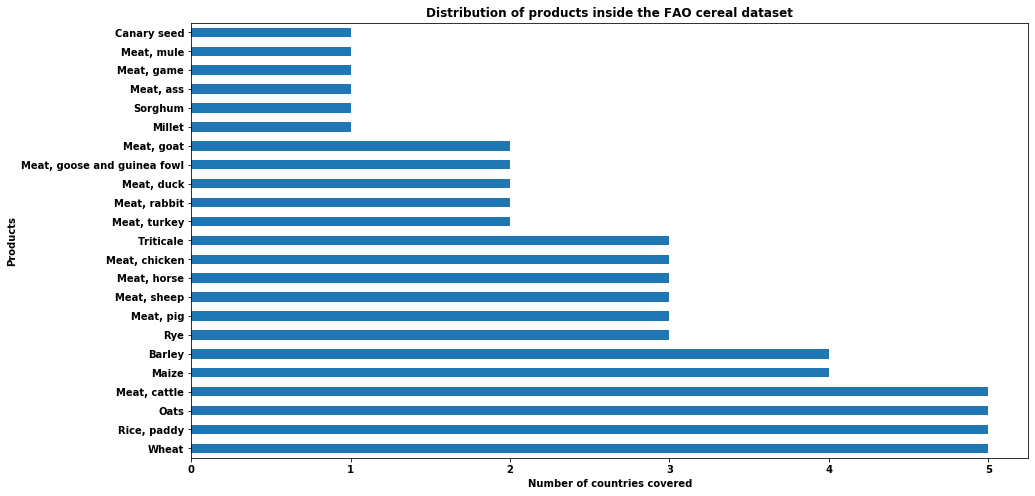

In [98]:
fao_prices.Item.value_counts().plot(kind="barh")
plt.title("Distribution of products inside the FAO cereal dataset")
plt.xlabel("Number of countries covered")
plt.ylabel("Products");

We need to report all in a single unit in `eu_prices`

In [99]:
eu_prices.Unit.unique()

array(['€/100 kg carcass weight', '€/100 kg', '€/100 kg net weight',
       '€/t', '€/100 Kg'], dtype=object)

As we are working with large amount of data and FAO as data in USD/tonnes, we take everything as EUR/tonn (multiply 10) and multiply by **1.10** (EUR/USD change)

In [100]:
eu_prices.loc[eu_prices['Unit'].str.contains('100'), 'Price'] = eu_prices.loc[eu_prices['Unit'].str.contains('100'), 'Price']\
                                                                .apply(lambda x: x*1.10*10)
eu_prices = eu_prices.drop(columns="Unit")

We now look, as we did for the `fao_prices`, if the prices we have are correctly represented among all our countries.  
First step we do in doing this, is to keep only the most recent data for each product inside each country

In [101]:
eu_prices = eu_prices.sort_values("Period", ascending=False).groupby(["Country", "Category", "Product"])\
                      .first().reset_index().drop(columns="Period")

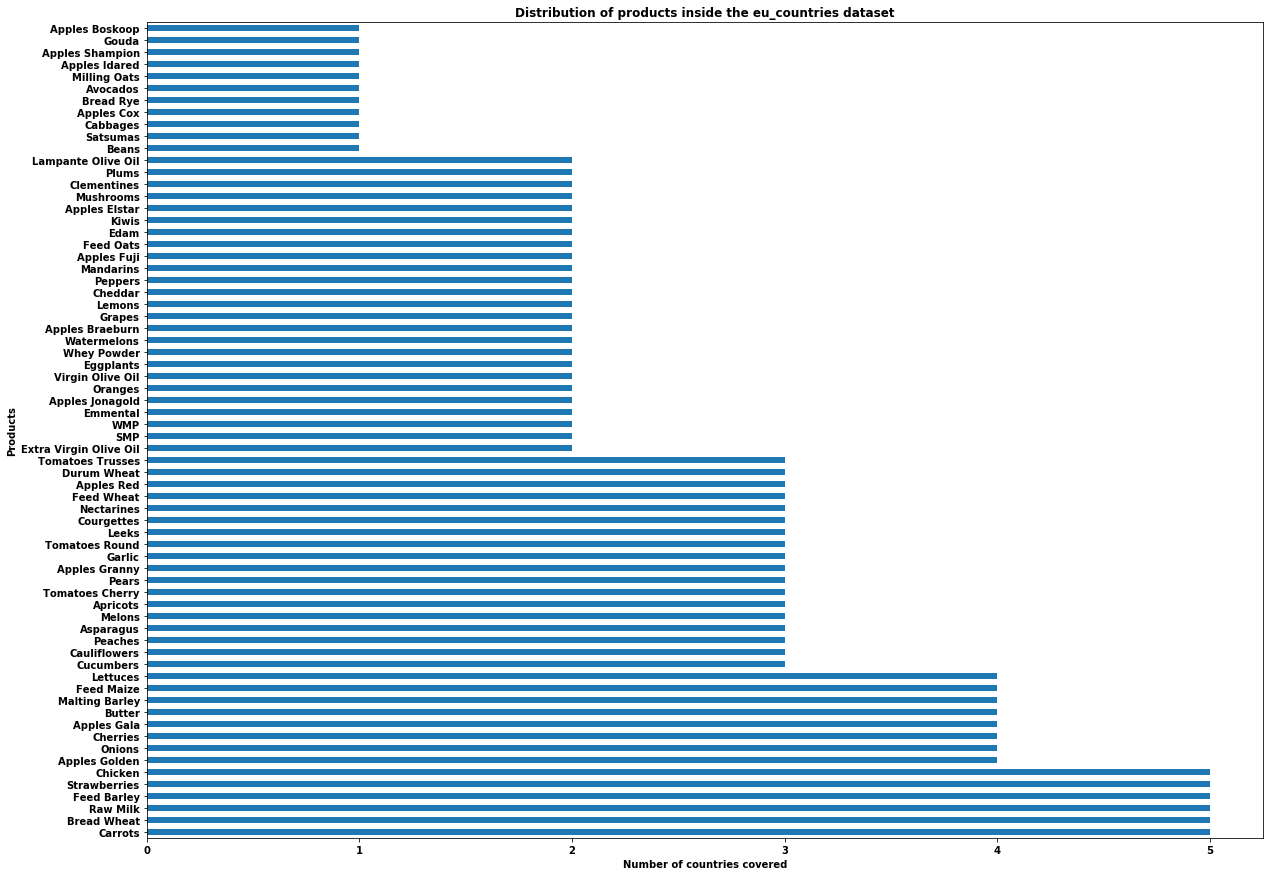

In [102]:
plt.figure(figsize=(20, 15))
eu_prices.Product.value_counts().plot(kind="barh")
plt.title("Distribution of products inside the eu_countries dataset")
plt.xlabel("Number of countries covered")
plt.ylabel("Products");

In [103]:
eu_prices.Product = eu_prices.Product.apply(lambda x: "Apples" if "Apples" in x else x)
eu_prices.Product = eu_prices.Product.apply(lambda x: "Tomatoes" if "Tomatoes" in x else x)
eu_prices.Product = eu_prices.Product.apply(lambda x: "Bread" if "Bread" in x else x)

In [104]:
# dropping and readd them
apples_eu = eu_prices[eu_prices.Product=="Apples"].groupby(["Country", "Category", "Product"]).agg("mean").reset_index()
eu_prices = eu_prices[~(eu_prices["Product"]=="Apples")].reset_index(drop=True)
tomatoes_eu = eu_prices[eu_prices.Product=="Tomatoes"].groupby(["Country", "Category", "Product"]).agg("mean").reset_index()
eu_prices = eu_prices[~(eu_prices["Product"]=="Tomatoes")].reset_index(drop=True)
bread_eu = eu_prices[eu_prices.Product=="Bread"].groupby(["Country", "Category", "Product"]).agg("mean").reset_index()
eu_prices = eu_prices[~(eu_prices["Product"]=="Bread")].reset_index(drop=True)
eu_prices = eu_prices.append(apples_eu)
eu_prices = eu_prices.append(tomatoes_eu)
eu_prices = eu_prices.append(bread_eu)

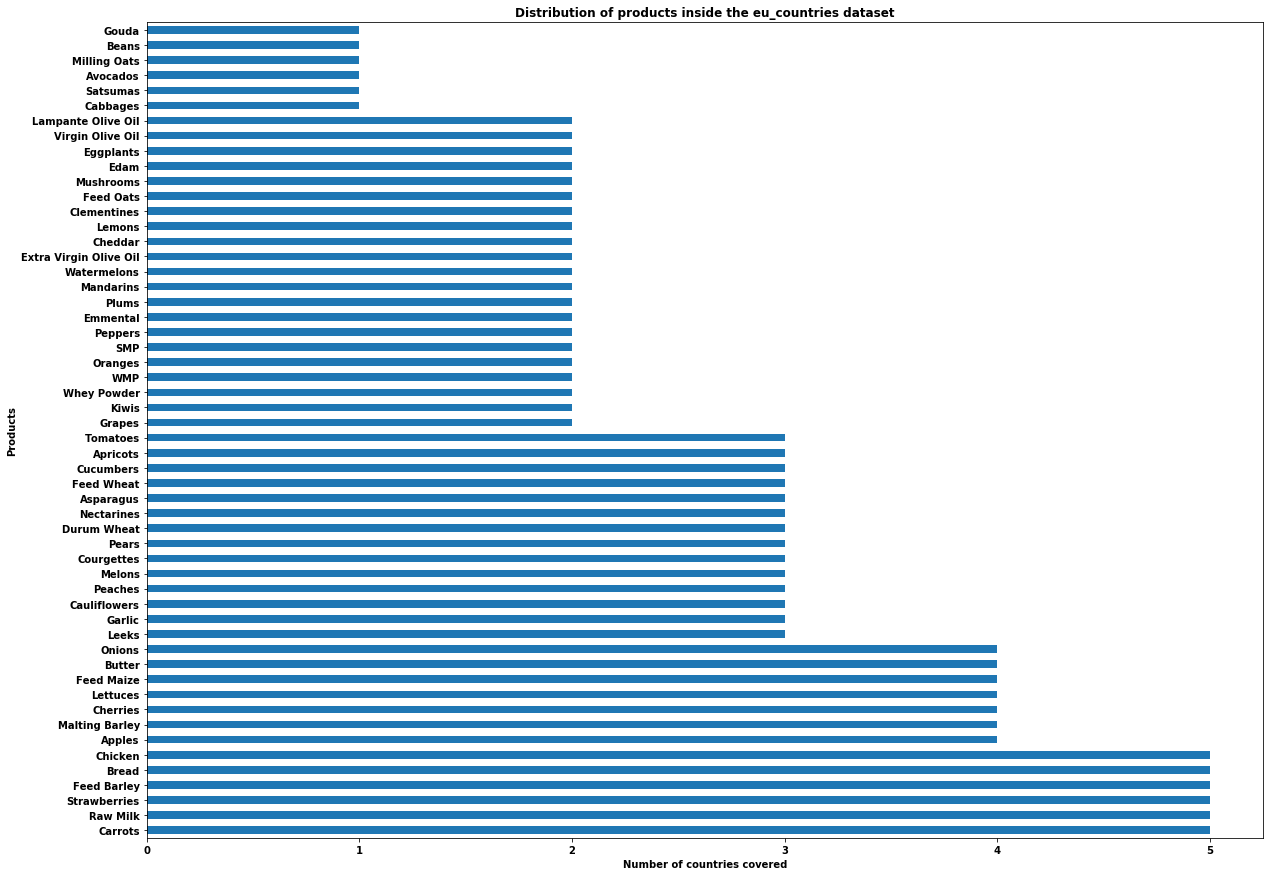

In [105]:
plt.figure(figsize=(20, 15))
eu_prices.Product.value_counts().plot(kind="barh")
plt.title("Distribution of products inside the eu_countries dataset")
plt.xlabel("Number of countries covered")
plt.ylabel("Products");

**Merging didn't solve the situation.**  
As a consequence, we decide to **drop all the products with not at least 4 counts** and put our *imputing efforts* just on them.

In [106]:
counts_eu = eu_prices.Product.value_counts()
possible_products = counts_eu[counts_eu >= len(best_countries) - 1].index
eu_prices = eu_prices[eu_prices.Product.isin(possible_products)]

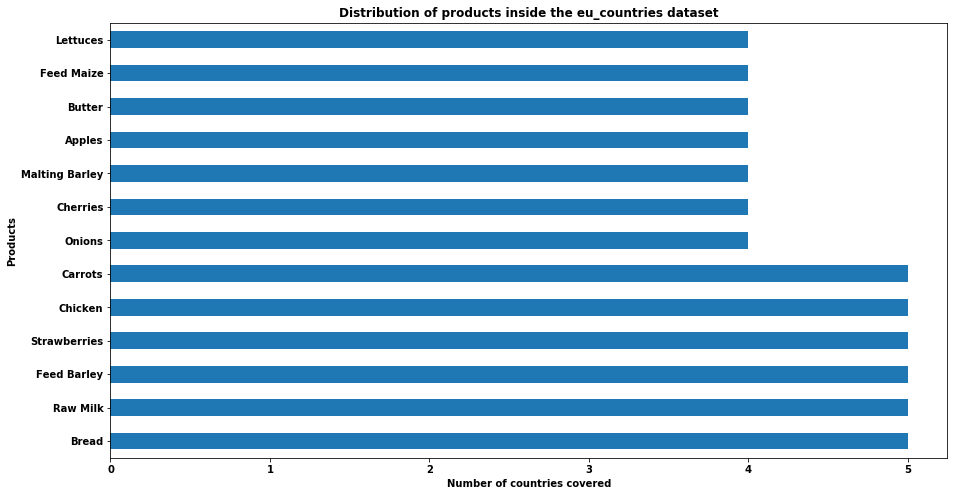

In [107]:
# replot to zoom on our interested products
eu_prices.Product.value_counts().plot(kind="barh")
plt.title("Distribution of products inside the eu_countries dataset")
plt.xlabel("Number of countries covered")
plt.ylabel("Products");

Printing the counts to understand which countries to impute. A country with all products should count **13 products**

In [108]:
eu_prices.Country.value_counts()

ES    13
DE    12
IT    12
FR    11
UK    10
Name: Country, dtype: int64

Only Spain has all the needed products. We need to impute all the others. We therefore proceed to print all the need in the other countries:

In [109]:
# set difference between the products
need_it = set(possible_products) - set(eu_prices[eu_prices.Country=="IT"].Product.values)
need_de = set(possible_products) - set(eu_prices[eu_prices.Country=="DE"].Product.values)
need_fr = set(possible_products) - set(eu_prices[eu_prices.Country=="FR"].Product.values)
need_uk = set(possible_products) - set(eu_prices[eu_prices.Country=="UK"].Product.values)

# printing
print("Missing product in Italy:", need_it)
print("Missing product in Germany:", need_de)
print("Missing product in France:", need_fr)
print("Missing product in United Kingdom:", need_uk)

Missing product in Italy: {'Malting Barley'}
Missing product in Germany: {'Onions'}
Missing product in France: {'Lettuces', 'Butter'}
Missing product in United Kingdom: {'Apples', 'Feed Maize', 'Cherries'}


#### Italy
We need to impute the **Malting Barley**. The actual italian price can be found [here](https://www.clal.it/en/index.php?section=conf_cereali#orzo), where the price is (today) 189 EUR/ton. We multiply by 1.10 to have the price in USD.

In [110]:
barley_italy = pd.DataFrame(np.array([["IT", "Vegetal Products", "Malting Barley", '%.2f'%(189*1.10)]]), columns=["Country", "Category", "Product", "Price"])
eu_prices = eu_prices.append(barley_italy).reset_index(drop=True)

#### Germany
We need to impute the **Onions**. We can easily expect that onions won't be part of our diet, so we can drop them from all of the country.

In [111]:
eu_prices = eu_prices[~(eu_prices.Product=="Onions")]

#### France
We need to impute **Lettuces** and **Butter**. For the second one, we can drop the aliment because it won't be part of the diet for sure. For the Lettuces, we can look to the FAO data directly from the [website](http://www.fao.org/faostat/en/#data/PP): 1296.3 in 2018

In [112]:
eu_prices = eu_prices[~(eu_prices.Product=="Butter")]
lettuce_france = pd.DataFrame(np.array([["FR", "Vegetable Products", "Lettuces", '%.2f'%(1269.3)]]), columns=["Country", "Category", "Product", "Price"])
eu_prices = eu_prices.append(lettuce_france).reset_index(drop=True)

In [113]:
eu_prices[(eu_prices.Product=="Feed Maize")]

,Country,Category,Product,Price
7,DE,Vegetal Products,Feed Maize,161.88
16,ES,Vegetal Products,Feed Maize,170.38
24,FR,Vegetal Products,Feed Maize,153.65
33,IT,Vegetal Products,Feed Maize,149.64


#### United Kingdom
We need to impute **Apples**, **Cherries** and **Feed Maize**. For Apples and cherries we can use FAO data: 1343.4 and 4574.9 respectively. The price of Maize can be found [here](https://ahdb.org.uk/cereals-oilseeds-markets), 195\$ per tonnes

In [114]:
apples_uk = pd.DataFrame(np.array([["UK", "Fruit Products", "Apples", '%.2f'%(1343.4)]]), columns=["Country", "Category", "Product", "Price"])
cherries_uk = pd.DataFrame(np.array([["UK", "Fruit Products", "Cherries", '%.2f'%(4574.9)]]), columns=["Country", "Category", "Product", "Price"])
maize_uk = pd.DataFrame(np.array([["UK", "Vegetal Products", "Feed Maize", '%.2f'%(195)]]), columns=["Country", "Category", "Product", "Price"])

eu_prices = eu_prices.append(apples_uk)
eu_prices = eu_prices.append(cherries_uk)
eu_prices = eu_prices.append(maize_uk).reset_index(drop=True)

Check if everything went right:

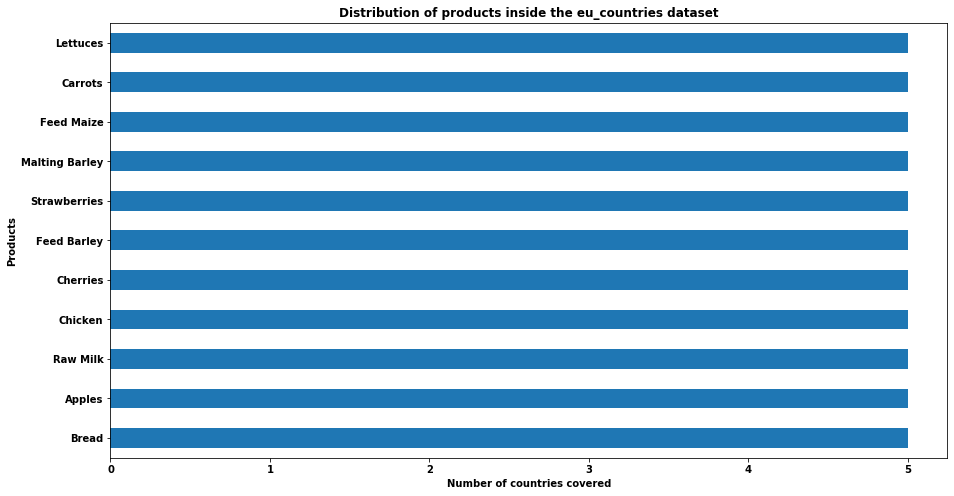

In [115]:
# replot to zoom on our interested products
eu_prices.Product.value_counts().plot(kind="barh")
plt.title("Distribution of products inside the eu_countries dataset")
plt.xlabel("Number of countries covered")
plt.ylabel("Products");

As we can see, the **Vegetables** category is not well represented by our actual dataset. For this reason, we consider **FAO data for vegetables** in order to fill the gaps:

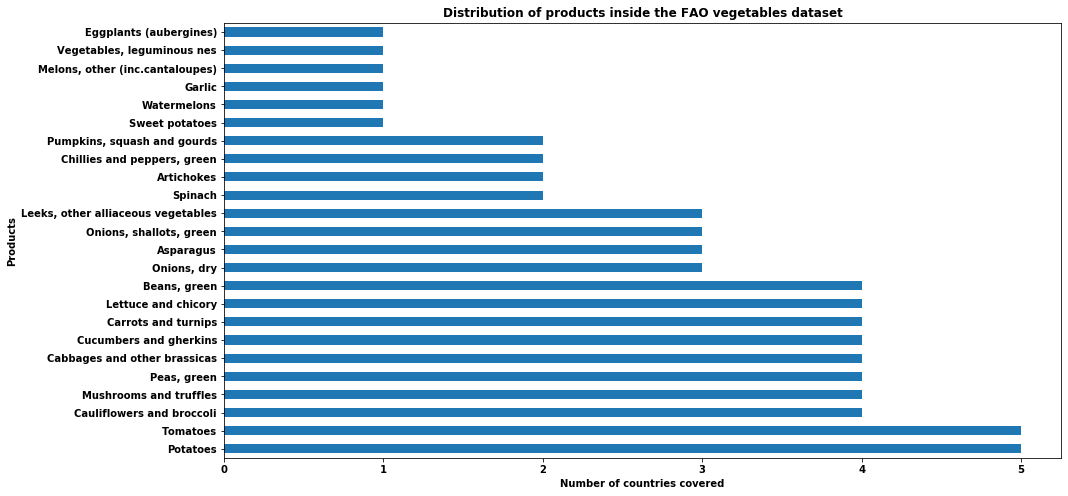

In [116]:
fao_vegetables_prc = pd.read_csv("data/raw/fao_vegetables_prices_201419.csv", usecols=["Area", "Item", "Value", "Year"])
fao_vegetables_prc = fao_vegetables_prc[fao_vegetables_prc.Area.isin(best_countries)]

fao_vegetables_prc = fao_vegetables_prc.sort_values("Year", ascending=False).groupby(["Area", "Item"])\
                      .first().reset_index().drop(columns="Year")

# plotting
fao_vegetables_prc.Item.value_counts().plot(kind="barh")
plt.title("Distribution of products inside the FAO vegetables dataset")
plt.xlabel("Number of countries covered")
plt.ylabel("Products");

As we did before, we take only the products present in at least **4 countries** for the next analysis:

In [117]:
counts_fao_veg = fao_vegetables_prc.Item.value_counts()
possible_products_veg = counts_fao_veg[counts_fao_veg >= len(best_countries) - 1].index
fao_vegetables_prc = fao_vegetables_prc[fao_vegetables_prc.Item.isin(possible_products_veg)]

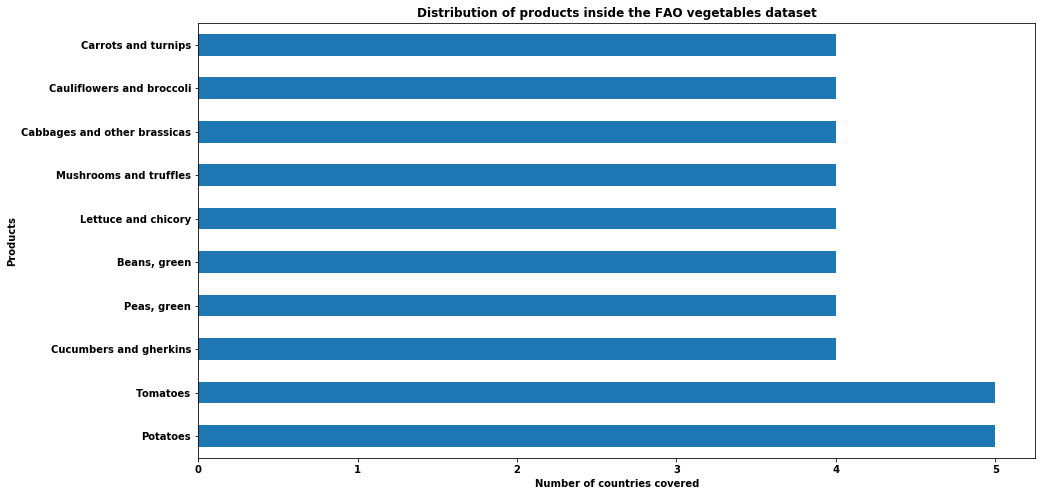

In [118]:
# replot to zoom on our interested products
fao_vegetables_prc.Item.value_counts().plot(kind="barh")
plt.title("Distribution of products inside the FAO vegetables dataset")
plt.xlabel("Number of countries covered")
plt.ylabel("Products");

We can also drop **Carrots** and **Lettuce** before already present in the precedent dataset:

In [119]:
fao_vegetables_prc = fao_vegetables_prc[~(fao_vegetables_prc.Item.isin(["Carrots and turnips", "Lettuce and chicory"]))]
possible_products_veg = possible_products_veg[~(possible_products_veg.isin(["Carrots and turnips", "Lettuce and chicory"]))]

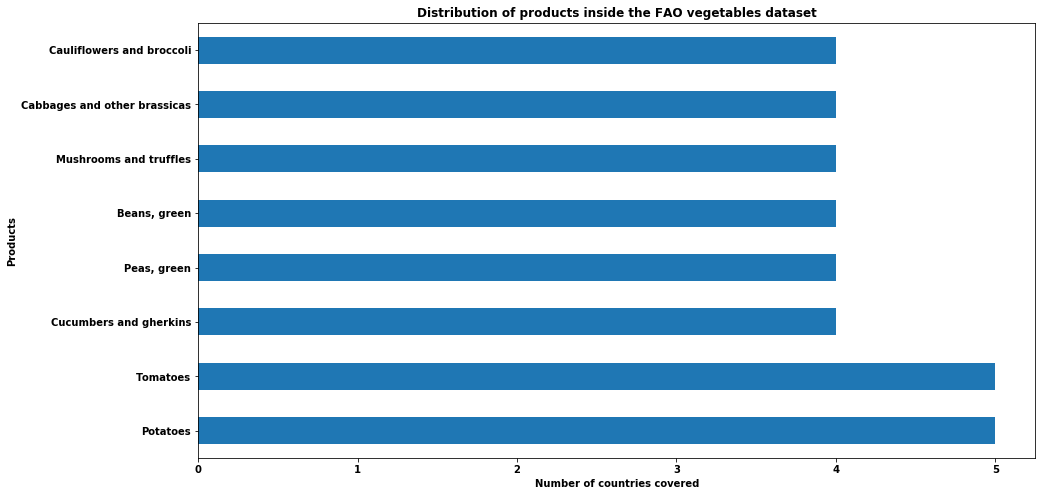

In [120]:
# replot to zoom on our interested products
fao_vegetables_prc.Item.value_counts().plot(kind="barh")
plt.title("Distribution of products inside the FAO vegetables dataset")
plt.xlabel("Number of countries covered")
plt.ylabel("Products");

Let's see how these products are represented:

In [121]:
fao_vegetables_prc.Area.value_counts()

Spain             8
France            8
United Kingdom    8
Germany           8
Italy             2
Name: Area, dtype: int64

The only country in which products are missing is **Italy**. We need to impute manually the prices of these products:

In [122]:
# set difference between the products
need_it = set(possible_products_veg) - set(fao_vegetables_prc[fao_vegetables_prc.Area=="Italy"].Item.values)

# printing
print("Missing product in Italy:", need_it)

Missing product in Italy: {'Cabbages and other brassicas', 'Mushrooms and truffles', 'Peas, green', 'Cucumbers and gherkins', 'Cauliflowers and broccoli', 'Beans, green'}


### Imputing Italy

The price for the **cucumbers** and the **cauliflowers** can be found in the `eu_prices` dataset

In [123]:
eu_prices2 = pd.read_csv("data/raw/europe_food_prices.csv", usecols=["Category", "Product desc", "Unit", "Country", "Period", "MP Market Price"])\
            .rename(columns={"Product desc": "Product", "MP Market Price":"Price"})
eu_prices2 = eu_prices2[eu_prices2.Country.isin(best_countries_code)]
eu_prices2 = eu_prices2[eu_prices2.Period.between(201400, 201910)]
eu_prices2 = eu_prices2.sort_values("Period", ascending=False).groupby(["Country", "Category", "Product"])\
                      .first().reset_index().drop(columns="Period")

In [124]:
eu_prices2[eu_prices2.Product=="Cucumbers"]

,Country,Category,Product,Unit,Price
63,ES,Vegetable Products,Cucumbers,€/100 kg net weight,49.81
101,FR,Vegetable Products,Cucumbers,€/100 kg net weight,114.55
144,IT,Vegetable Products,Cucumbers,€/100 kg net weight,68.00


In [125]:
eu_prices2[eu_prices2.Product=="Cauliflowers"]

,Country,Category,Product,Unit,Price
61,ES,Vegetable Products,Cauliflowers,€/100 kg net weight,25.20
99,FR,Vegetable Products,Cauliflowers,€/100 kg net weight,40.68
142,IT,Vegetable Products,Cauliflowers,€/100 kg net weight,62.71


In [126]:
#prices are in Eur/100 kg, we need usd/tonnes
cucumbers = pd.DataFrame(np.array([["Italy", "Cucumbers and gherkins", 68.00*1.10*10]]), columns=["Area", "Item", "Value"])
cauliflowers = pd.DataFrame(np.array([["Italy", "Cauliflowers and broccoli", 62.71*1.10*10]]), columns=["Area", "Item", "Value"])


fao_vegetables_prc = fao_vegetables_prc.append(cucumbers)
fao_vegetables_prc = fao_vegetables_prc.append(cauliflowers).reset_index(drop=True)

For the **peas** and the **beans** of 2017 in Italy can be found [here](http://www.codima.info/trunk/nor_file_107_decreto-ministeriale-n.-0031908-del-29-dicembre-2016-prezzi_parte_1-.pdf) (page in Italian)  
The price is **120.33€/100kg** for the peas and **175.56€/100kg** for the beans

In [127]:
#prices are in Eur/100 kg, we need usd/tonnes
peas = pd.DataFrame(np.array([["Italy", "Peas, green", 120.33*1.10*10]]), columns=["Area", "Item", "Value"])
beans = pd.DataFrame(np.array([["Italy", "Beans, green", 175.56*1.10*10]]), columns=["Area", "Item", "Value"])


fao_vegetables_prc = fao_vegetables_prc.append(peas)
fao_vegetables_prc = fao_vegetables_prc.append(beans).reset_index(drop=True)

Unfortunately, we didn't find any reliable price for **Cabbages and mushrooms**, so we drop them:

In [128]:
fao_vegetables_prc = fao_vegetables_prc[~(fao_vegetables_prc.Item.isin(["Cabbages and other brassicas", "Mushrooms and truffles"]))]

Final check on these products

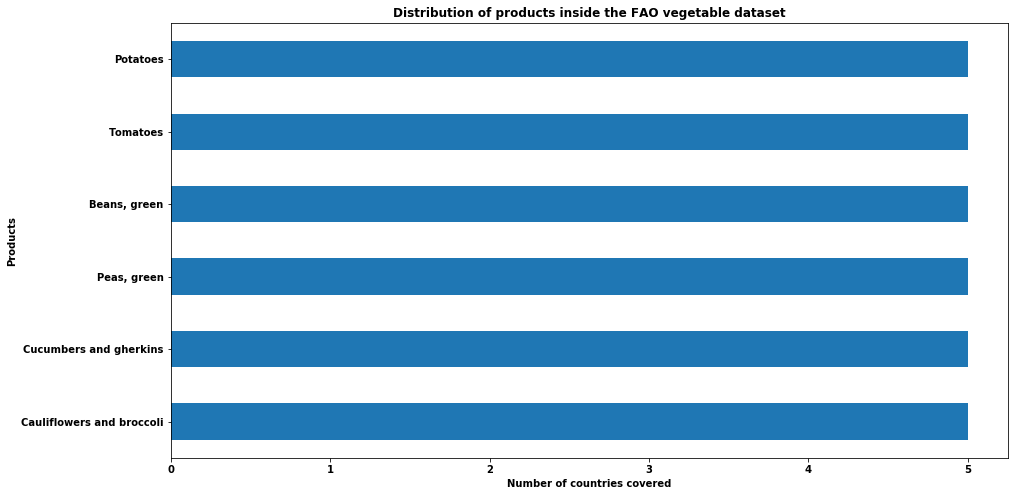

In [129]:
fao_vegetables_prc.Item.value_counts().plot(kind="barh")
plt.title("Distribution of products inside the FAO vegetable dataset")
plt.xlabel("Number of countries covered")
plt.ylabel("Products");

We also now rename the codes in  `eu_prices` to full name of nations before merging

In [130]:
dict_country = dict(zip(best_countries_code, best_countries))
eu_prices = eu_prices.replace({"Country":dict_country})

Final step is combining the three dataframe together. We modify the needed products from the FAO datasets and adapt it to `eu_prices`

In [131]:
counts_fao = fao_prices.Item.value_counts()
fao_products = counts_fao[counts_fao == len(best_countries)].index
fao_prices = fao_prices[fao_prices.Item.isin(fao_products)]

In [132]:
# dropping the no longer needed category column from eu
eu_prices.drop(columns="Category", inplace=True)

In [133]:
fao_prices = fao_prices.replace({"Item":{"Rice, paddy": "Rice", "Meat, cattle": "Meat"}})
fao_prices = fao_prices[["Area", "Item", "Value"]]
fao_prices = fao_prices.rename(columns={"Item": "Product", "Area":"Country", "Value":"Price"})
fao_vegetables_prc = fao_vegetables_prc.replace({"Item":{"Cauliflowers and broccoli": "Cauliflowers", "Peas, green": "Peas", "Beans, green": "Beans", "Cucumbers and gherkins": "Cucumbers"}})
fao_vegetables_prc = fao_vegetables_prc[["Area", "Item", "Value"]]
fao_vegetables_prc = fao_vegetables_prc.rename(columns={"Item": "Product", "Area":"Country", "Value":"Price"})
prices = eu_prices.append(fao_prices).append(fao_vegetables_prc).sort_values(by="Product").reset_index(drop=True)
prices.head()

,Country,Product,Price
0,United Kingdom,Apples,1343.40
1,Italy,Apples,713.743
2,France,Apples,1029.79
3,Spain,Apples,898.04
4,Germany,Apples,597.443


In [134]:
print("The final products present in the dataset are: {}".format(prices.Product.unique()))

The final products present in the dataset are: ['Apples' 'Beans' 'Bread' 'Carrots' 'Cauliflowers' 'Cherries' 'Chicken'
 'Cucumbers' 'Feed Barley' 'Feed Maize' 'Lettuces' 'Malting Barley' 'Meat'
 'Oats' 'Peas' 'Potatoes' 'Raw Milk' 'Rice' 'Strawberries' 'Tomatoes'
 'Wheat']


We have finally build our **final prices dataset!**

## 3) Filtering the food dataset  
Now that we know the set of products between we can choose, it's time to filter the `USDA_food` accordingly

In [157]:
# defining the set of foods between we can choose
foods = prices.Product.unique()

In [158]:
food_properties[food_properties["Food Name"].str.contains('|'.join(foods), case=False)]

,Food Group,Food Name,Protein (g),Carbohydrates (g),Fat (g)
1,Poultry Products,"Chicken, broilers or fryers, meat and skin and...",18.33,0.13,14.83
6,Poultry Products,"Chicken, broilers or fryers, meat and skin, raw",18.60,0.00,15.06
11,Poultry Products,"Chicken, broilers or fryers, meat only, raw",21.39,0.00,3.08
15,Poultry Products,"Chicken, broilers or fryers, skin only, raw",13.33,0.00,32.35
20,Poultry Products,"Chicken, broilers or fryers, giblets, raw",17.88,1.80,4.47
...,...,...,...,...,...
4052,Beef Products,"Beef, ground, 95% lean meat / 5% fat, raw",21.41,0.00,5.00
4057,Beef Products,"Beef, ground, 90% lean meat / 10% fat, raw",20.00,0.00,10.00
4062,Beef Products,"Beef, ground, 85% lean meat / 15% fat, raw",18.59,0.00,15.00
4067,Beef Products,"Beef, ground, 80% lean meat / 20% fat, raw",17.17,0.00,20.00


209rows, but there are multiple matches. Let's look to the elements that don't have a match:

In [159]:
# find the set of total foods and set to lower
total_foods = food_properties["Food Name"].unique()
total_foods = [t.lower() for t in total_foods]

# consider also foods to lower fo check the match
foods = [f.lower()for f in foods]

In [160]:
# find set of not matching
not_matching = [f for f in foods if not any(f in t for t in total_foods)]
len(not_matching)

9

In [161]:
not_matching

['cauliflowers',
 'cucumbers',
 'feed barley',
 'feed maize',
 'lettuces',
 'malting barley',
 'oats',
 'raw milk',
 'wheat']

We can try to divide the multiple words, also remove duplicates after that

In [162]:
foods = [f.replace(",","").replace("(", "").replace(")", "").split() for f in foods]
foods = [l for sublist in foods for l in sublist]
foods = list(set(foods))

Second step is removing all generated stopwords and add singulars

In [163]:
stop_words = stopwords.words('english')
stop_words += ["feed", "raw"]
foods = [f for f in foods if f not in stop_words]
lem = WordNetLemmatizer()
singular = [lem.lemmatize(f) for f in foods]
foods += singular
foods = list(set(foods))
foods = [f for f in foods if f not in stop_words]

In [164]:
# printing the set of food
foods

['lettuces',
 'potatoes',
 'pea',
 'strawberries',
 'cherries',
 'barley',
 'potato',
 'bread',
 'cauliflower',
 'carrots',
 'cucumber',
 'cherry',
 'oats',
 'beans',
 'cauliflowers',
 'peas',
 'bean',
 'apple',
 'cucumbers',
 'strawberry',
 'tomato',
 'carrot',
 'lettuce',
 'malting',
 'milk',
 'rice',
 'maize',
 'meat',
 'oat',
 'tomatoes',
 'apples',
 'wheat',
 'chicken']

It's possible to notice that _"meat"_ is too much generic for our purpose, as we considered cow or beef in analyzing the prices. For this reason, we remove meat and add "cow" and "beef"

In [165]:
foods = [f for f in foods if f!="meat"]
foods += ["beef", "cow"]

New matching check:

In [166]:
food_properties[food_properties["Food Name"].str.contains('|'.join(foods), case=False)]

,Food Group,Food Name,Protein (g),Carbohydrates (g),Fat (g)
1,Poultry Products,"Chicken, broilers or fryers, meat and skin and...",18.33,0.13,14.83
6,Poultry Products,"Chicken, broilers or fryers, meat and skin, raw",18.60,0.00,15.06
11,Poultry Products,"Chicken, broilers or fryers, meat only, raw",21.39,0.00,3.08
15,Poultry Products,"Chicken, broilers or fryers, skin only, raw",13.33,0.00,32.35
20,Poultry Products,"Chicken, broilers or fryers, giblets, raw",17.88,1.80,4.47
...,...,...,...,...,...
4142,Beef Products,"Beef, round, tip round, roast, separable lean ...",21.38,0.00,3.35
4145,Beef Products,"Beef, flank, steak, separable lean only, trimm...",21.57,0.00,5.47
4146,Beef Products,"Beef, flank, steak, separable lean only, trimm...",21.43,0.00,5.00
4147,Beef Products,"Beef, brisket, flat half, separable lean and f...",18.12,0.12,22.15


We have a good set of products now, so we can stop here for the next considerations

In [167]:
poss_diet = food_properties[food_properties["Food Name"].str.contains('|'.join(foods), case=False)]

Check of our residue groups:

In [168]:
poss_diet["Food Group"].unique()

array(['Poultry Products', 'Fruits and Fruit Juices',
       'Vegetables and Vegetable Products', 'Beef Products',
       'Finfish and Shellfish Products', 'Legumes and Legume Products',
       'Lamb, Veal, and Game Products', 'Cereal Grains and Pasta'],
      dtype=object)

Fish products seems a bit strange for what we analyzed so far, check on it:

In [169]:
poss_diet[poss_diet["Food Group"] == "Finfish and Shellfish Products"]

,Food Group,Food Name,Protein (g),Carbohydrates (g),Fat (g)
2312,Finfish and Shellfish Products,"Fish, anchovy, european, raw",20.35,0.0,4.84
2364,Finfish and Shellfish Products,"Fish, milkfish, raw",20.53,0.0,6.73
2437,Finfish and Shellfish Products,"Fish, turbot, european, raw",16.05,0.0,2.95


Finfish and Shellfish Products is not really represented by our prices database, so we drop the category

In [170]:
poss_diet = poss_diet[~poss_diet["Food Group"].isin(["Finfish and Shellfish Products"])].reset_index(drop=True)

Let's now adjust the units. The grams of proteins in 100g serve **[grams of proteins/100g]** times the kcalalories in 1 gram of proteins **[kcal/g of proteins]** will result in the kilocalories obtained from proteins for 100g serve **[kcal/100g]**. Same argument che be extended to carbohydrates and fat.  <br /> According to the [National Agriculture Library](https://www.nal.usda.gov/fnic/how-many-calories-are-one-gram-fat-carbohydrate-or-protein):
 - 1 gram of protein corresponds to **4 kcal**
 - 1 gram of carbohydrates corresponds to **4 kcal**
 - 1 gram of fat corresponds to **9 kcal**

According to what has been said above, we will multiply the values and obtain a new dataframe `diet_kcal` in which values have units of **[kcal/100g]**

In [171]:
#multiply values with vector of kcal/g, merging to keep Food 
kcal_g = np.array([4,4,9])
diet_kcal = poss_diet[["Food Group", "Food Name"]].merge(poss_diet[poss_diet.columns[2:]].multiply(kcal_g),left_index=True, right_index=True)
diet_kcal.rename(columns={'Protein (g)':'Protein (kcal/100g)',
                          'Carbohydrates (g)':'Carbohydrates (kcal/100g)',
                          'Fat (g)':'Fat (kcal/100g)'}, 
                 inplace=True)
diet_kcal.head()

,Food Group,Food Name,Protein (kcal/100g),Carbohydrates (kcal/100g),Fat (kcal/100g)
0,Poultry Products,"Chicken, broilers or fryers, meat and skin and...",73.32,0.52,133.47
1,Poultry Products,"Chicken, broilers or fryers, meat and skin, raw",74.40,0.00,135.54
2,Poultry Products,"Chicken, broilers or fryers, meat only, raw",85.56,0.00,27.72
3,Poultry Products,"Chicken, broilers or fryers, skin only, raw",53.32,0.00,291.15
4,Poultry Products,"Chicken, broilers or fryers, giblets, raw",71.52,7.20,40.23


The next point we are going to do now is trying to give a rank to each product taking into account the necessity that each person, in their diet, should have their calories coming (**REFERENCE**): 
* 55% from proteins
* 25% from carbohydrates 
* 20% from fats.
In order to do so, we apply a greedy ranking based on how much a particular food is far from respecting this division.

In [172]:
def rank_food(food):
    prot = food['Protein (kcal/100g)']
    carb = food['Carbohydrates (kcal/100g)']
    fat = food['Fat (kcal/100g)']
    
    if (prot == 0 and carb == 0 and fat == 0):
        return -1
    
    tot = prot + carb + fat
    
    err_prot = abs(tot*0.55/4 - prot) / 100
    err_carb = abs(tot*0.25/4 - carb) / 100
    err_fat = abs(tot*0.20/9 - fat) / 100
    
    avg_err = (err_prot + err_carb + err_fat)/3
    
    return avg_err

In [173]:
diet_kcal['rank'] = diet_kcal.apply(rank_food, axis=1)

In the next step we take the best **3** out of each group (because there may be incostintecies in the results due to the filtering process).  
From these, we then choose our **representative for each group**. We will use this to compute the final diet in the next and final step.

In [174]:
diet_kcal.groupby(["Food Group"]).apply(lambda x: x.sort_values(['rank'])\
                                 .reset_index(drop=True).groupby("Food Group").head(3)).reset_index(drop=True)

,Food Group,Food Name,Protein (kcal/100g),Carbohydrates (kcal/100g),Fat (kcal/100g),rank
0,Beef Products,"Beef, New Zealand, imported, variety meats and...",59.44,0.00,17.82,0.232495
1,Beef Products,"Beef, variety meats and by-products, tripe, raw",48.28,0.00,33.21,0.245225
2,Beef Products,"Beef, New Zealand, imported, variety meats and...",62.72,0.00,23.76,0.260241
3,Cereal Grains and Pasta,"Wild rice, raw",58.92,299.60,9.72,0.954696
4,Cereal Grains and Pasta,"Barley, pearled, raw",39.64,310.88,10.44,1.002436
5,Cereal Grains and Pasta,"Oat bran, raw",69.20,264.88,63.27,1.030167
6,Fruits and Fruit Juices,"Rose-apples, raw",2.40,22.80,2.70,0.081908
7,Fruits and Fruit Juices,"Pitanga, (surinam-cherry), raw",3.20,29.96,3.60,0.107667
8,Fruits and Fruit Juices,"Strawberries, raw",2.68,30.72,2.70,0.108818
9,"Lamb, Veal, and Game Products","Lamb, New Zealand, imported, sweetbread, raw",44.00,0.00,28.44,0.217991


Let's further analyze this results.  
We can start from the category that is less represented (2 results instead of 3): **Lamb, Veal, and Game Products**

In [175]:
diet_kcal[diet_kcal["Food Group"] == "Lamb, Veal, and Game Products"]

,Food Group,Food Name,Protein (kcal/100g),Carbohydrates (kcal/100g),Fat (kcal/100g),rank
298,"Lamb, Veal, and Game Products","Game meat, beefalo, composite of cuts, raw",93.2,0.0,43.20,0.410463
299,"Lamb, Veal, and Game Products","Goat, raw",82.4,0.0,20.79,0.310525
300,"Lamb, Veal, and Game Products","Lamb, New Zealand, imported, sweetbread, raw",44.0,0.0,28.44,0.217991


As we can see, this category doesn't really have a representation. The residue results are here just as consequence of the filtering process (using `str.contains` caused this).
**For this reason, we drop it**, than we increase the range of choosable products from 3 to **5** and reprint.

In [176]:
diet_kcal = diet_kcal[~diet_kcal["Food Group"].isin(["Lamb, Veal, and Game Products"])].reset_index(drop=True)

In [177]:
diet_kcal.groupby(["Food Group"]).apply(lambda x: x.sort_values(['rank'])\
                                 .reset_index(drop=True).groupby("Food Group").head(5)).reset_index(drop=True)

,Food Group,Food Name,Protein (kcal/100g),Carbohydrates (kcal/100g),Fat (kcal/100g),rank
0,Beef Products,"Beef, New Zealand, imported, variety meats and...",59.44,0.00,17.82,0.232495
1,Beef Products,"Beef, variety meats and by-products, tripe, raw",48.28,0.00,33.21,0.245225
2,Beef Products,"Beef, New Zealand, imported, variety meats and...",62.72,0.00,23.76,0.260241
3,Beef Products,"Beef, variety meats and by-products, lungs, raw",64.80,0.00,22.50,0.262708
4,Beef Products,"Beef, variety meats and by-products, kidneys, raw",69.60,1.16,27.81,0.288889
5,Cereal Grains and Pasta,"Wild rice, raw",58.92,299.60,9.72,0.954696
6,Cereal Grains and Pasta,"Barley, pearled, raw",39.64,310.88,10.44,1.002436
7,Cereal Grains and Pasta,"Oat bran, raw",69.20,264.88,63.27,1.030167
8,Cereal Grains and Pasta,"Rice, brown, medium-grain, raw",30.00,304.68,24.12,1.059122
9,Cereal Grains and Pasta,"Rice, white, medium-grain, raw, enriched",26.44,317.36,5.22,1.065442


Now the shape of our final diet is **way more clear**:
- From the _**Beef Products**_ category we have a great variety of meats. We can take **the median over the first 10 rows** to have our representative beef nutrients.
- From the _**Cereal Grains and Pasta**_ group a good product would be one of **rice, bearley** or **oat**. We keep all of them for know. Further analysis will be on the next section
- From the _**Fruits and Fruit Juices**_ category we take the **Strawberries** and **Apples** (not rose-apples as showed here but apples, as there are some in the dataframe). The other products are probably show due to some inconsistence with the foods presented before.
- From **_Poultry Products_** we take **Chicken, roasting, light meat, meat only, raw** as it's the most simple one
- For the _**Legumes and Legume Products**_ and _**Vegetables and Vegetable Products**_ we need further analysis (because these two categories can be very useful for our analysis):
    - From _**Legumes and Legume Products**_ we are for sure **Beans**, but the yogurt there presented is an inconsistence. Therefore, we need further explorations.
    - From _**Vegetables and Vegetable Products**_ we could take **Lettuce, green leaf, raw** and **cucumber**. We should analyze if there's the possibility to take other products.

We can now build the **final dataframe** with nutrient for each product.

In [214]:
prod_diet_final = pd.DataFrame(columns=["Product", "Protein (kcal/100g)", "Carbohydrates (kcal/100g)","Fat (kcal/100g)"])

#### Beef Products

In [215]:
# taking an average over the first 5 beef product
best_beef = diet_kcal[diet_kcal["Food Group"]=="Beef Products"].sort_values(by="rank").head(10)
beef_repr = [best_beef["Protein (kcal/100g)"].median(),\
             best_beef["Carbohydrates (kcal/100g)"].median(),\
             best_beef["Fat (kcal/100g)"].median()]
beef_list = ["Beef Meat"] + beef_repr
beef = pd.DataFrame(np.array([beef_list]), columns=["Product", "Protein (kcal/100g)", "Carbohydrates (kcal/100g)","Fat (kcal/100g)"])
prod_diet_final = prod_diet_final.append(beef)

#### Cereal Grains and Pasta

In [216]:
# taking the top 3 in cereals (rice, bearley, oat)
best_cereal = diet_kcal[diet_kcal["Food Group"]=="Cereal Grains and Pasta"].sort_values(by="rank").head(3)
best_cereal = best_cereal.drop(columns=["Food Group", "rank"]).rename(columns={"Food Name":"Product"})
best_cereal = best_cereal.replace({"Product":{"Wild rice, raw": "Rice", "Barley, pearled, raw": "Barley", "Oat bran, raw": "Oats"}})
prod_diet_final = prod_diet_final.append(best_cereal)

#### Fruits and Fruit Juices
By further analysis, we discovered that it's possible to add also **cherries** to the possible diet. So we keep that too

In [217]:
# taking apples, cherries and strawberries 
fruits = diet_kcal[(diet_kcal["Food Name"]=="Apples, raw, with skin") | (diet_kcal["Food Name"]=="Strawberries, raw") | (diet_kcal["Food Name"]=="Cherries, sour, red, raw")]
fruits = fruits.drop(columns=["Food Group", "rank"]).rename(columns={"Food Name":"Product"})
fruits = fruits.replace({"Product":{"Apples, raw, with skin": "Apples", "Cherries, sour, red, raw": "Cherries", "Strawberries, raw": "Strawberries"}})
prod_diet_final = prod_diet_final.append(fruits)

#### Poultry Products

In [218]:
# just take Chicken, roasting, light meat, meat only, raw
poultry = diet_kcal[diet_kcal["Food Name"]=="Chicken, roasting, light meat, meat only, raw"]
poultry = poultry.drop(columns=["Food Group", "rank"]).rename(columns={"Food Name":"Product"})
poultry = poultry.replace({"Product":{"Chicken, roasting, light meat, meat only, raw": "Chicken"}})
prod_diet_final = prod_diet_final.append(poultry)

#### Legumes and Legume Products

In [219]:
check_leg = diet_kcal[diet_kcal["Food Group"]=="Legumes and Legume Products"]
check_leg[check_leg["Food Name"].str.contains("bean", case=False)].head(5)

,Food Group,Food Name,Protein (kcal/100g),Carbohydrates (kcal/100g),Fat (kcal/100g),rank
261,Legumes and Legume Products,"Beans, adzuki, mature seeds, raw",79.48,251.60,4.77,0.888678
262,Legumes and Legume Products,"Beans, black, mature seeds, raw",86.40,249.44,12.78,0.903830
263,Legumes and Legume Products,"Beans, black turtle, mature seeds, raw",85.00,253.00,8.10,0.897296
264,Legumes and Legume Products,"Beans, cranberry (roman), mature seeds, raw",92.12,240.20,11.07,0.890270
265,Legumes and Legume Products,"Beans, french, mature seeds, raw",75.24,256.44,18.18,0.907044


In [220]:
check_leg[check_leg["Food Name"].str.contains("pea", case=False)].head(5)

,Food Group,Food Name,Protein (kcal/100g),Carbohydrates (kcal/100g),Fat (kcal/100g),rank
278,Legumes and Legume Products,"Chickpeas (garbanzo beans, bengal gram), matur...",81.88,251.80,54.36,1.006030
279,Legumes and Legume Products,"Cowpeas, catjang, mature seeds, raw",95.40,238.56,18.63,0.914122
280,Legumes and Legume Products,"Cowpeas, common (blackeyes, crowder, southern)...",94.08,240.12,11.34,0.895844
287,Legumes and Legume Products,"Peas, green, split, mature seeds, raw",95.28,254.96,10.44,0.935096
288,Legumes and Legume Products,"Peanuts, all types, raw",103.20,64.52,443.16,1.583763


As we can see, we have both the product we mentioned before. As these are the **only 2 types of legumes we have**, as their **nutriments provision is usually high**, we decide to keep both of them for our next analysis.

In [221]:
# Taking one for beans and one for peas
beans = diet_kcal[diet_kcal["Food Name"]=="Beans, adzuki, mature seeds, raw"]
beans = beans.drop(columns=["Food Group", "rank"]).rename(columns={"Food Name":"Product"})
beans = beans.replace({"Product":{"Beans, adzuki, mature seeds, raw": "Beans"}})

peas = diet_kcal[diet_kcal["Food Name"]=="Peas, green, split, mature seeds, raw"]
peas = peas.drop(columns=["Food Group", "rank"]).rename(columns={"Food Name":"Product"})
peas = peas.replace({"Product":{"Peas, green, split, mature seeds, raw": "Peas"}})

prod_diet_final = prod_diet_final.append(beans)
prod_diet_final = prod_diet_final.append(peas)

#### Vegetables and Vegetable Products

In [222]:
diet_kcal[diet_kcal["Food Group"]=="Vegetables and Vegetable Products"].sort_values(by="rank").head(10)

,Food Group,Food Name,Protein (kcal/100g),Carbohydrates (kcal/100g),Fat (kcal/100g),rank
104,Vegetables and Vegetable Products,"Cucumber, peeled, raw",2.36,8.64,1.44,0.032252
107,Vegetables and Vegetable Products,"Lettuce, butterhead (includes boston and bibb ...",5.40,8.92,1.98,0.042259
111,Vegetables and Vegetable Products,"Lettuce, red leaf, raw",5.32,9.04,1.98,0.042363
109,Vegetables and Vegetable Products,"Lettuce, iceberg (includes crisphead types), raw",3.60,11.88,1.26,0.043400
103,Vegetables and Vegetable Products,"Cucumber, with peel, raw",2.60,14.52,0.99,0.046952
133,Vegetables and Vegetable Products,"Tomatoes, yellow, raw",3.92,11.92,2.34,0.047133
110,Vegetables and Vegetable Products,"Lettuce, green leaf, raw",5.44,11.48,1.35,0.047367
132,Vegetables and Vegetable Products,"Tomatoes, orange, raw",4.64,12.72,1.71,0.049441
90,Vegetables and Vegetable Products,"Balsam-pear (bitter gourd), pods, raw",4.00,14.80,1.53,0.052707
108,Vegetables and Vegetable Products,"Lettuce, cos or romaine, raw",4.92,13.16,2.70,0.053874


As we can see, in the best **10 vegetables** are present **Lettuce, cucumber and tomatoes** (different kinds for the latter).  
We decide to take the three (we search for the red one in case of tomatoe, as it is the most common).

In [223]:
# take Lettuce, green leaf, raw and Cucumber
lettuce = diet_kcal[diet_kcal["Food Name"]=="Lettuce, green leaf, raw"]
lettuce = lettuce.drop(columns=["Food Group", "rank"]).rename(columns={"Food Name":"Product"})
lettuce = lettuce.replace({"Product":{"Lettuce, green leaf, raw": "Lettuces"}})

cucumber = diet_kcal[diet_kcal["Food Name"]=="Cucumber, peeled, raw"]
cucumber = cucumber.drop(columns=["Food Group", "rank"]).rename(columns={"Food Name":"Product"})
cucumber = cucumber.replace({"Product":{"Cucumber, peeled, raw": "Cucumbers"}})

prod_diet_final = prod_diet_final.append(lettuce)
prod_diet_final = prod_diet_final.append(cucumber)

In [224]:
#average over tomatoes
tomatoes = diet_kcal[diet_kcal["Food Name"].str.contains("tomatoe", case=False)]
tomatoes

,Food Group,Food Name,Protein (kcal/100g),Carbohydrates (kcal/100g),Fat (kcal/100g),rank
125,Vegetables and Vegetable Products,"Tomatoes, green, raw",4.80,20.40,1.80,0.070000
126,Vegetables and Vegetable Products,"Tomatoes, red, ripe, raw, year round average",3.52,15.56,1.80,0.054133
132,Vegetables and Vegetable Products,"Tomatoes, orange, raw",4.64,12.72,1.71,0.049441
133,Vegetables and Vegetable Products,"Tomatoes, yellow, raw",3.92,11.92,2.34,0.047133


Found the name for the red tomatoe. Add it to the dataset:

In [225]:
tomatoes = diet_kcal[diet_kcal["Food Name"]=="Tomatoes, red, ripe, raw, year round average"]
tomatoes = tomatoes.drop(columns=["Food Group", "rank"]).rename(columns={"Food Name":"Product"})
tomatoes = tomatoes.replace({"Product":{"Tomatoes, red, ripe, raw, year round average": "Tomatoes"}})

prod_diet_final = prod_diet_final.append(tomatoes).reset_index(drop=True).set_index("Product")

We can finally look at **our final diet dataframe** `prod_diet_final`. This dataframe will be used in the next section to build an optimal diet **based on the production prices**

In [226]:
prod_diet_final

,Protein (kcal/100g),Carbohydrates (kcal/100g),Fat (kcal/100g)
Product,,,
Beef Meat,70.24,0.0,28.98
Rice,58.92,299.6,9.72
Barley,39.64,310.88,10.44
Oats,69.2,264.88,63.27
Apples,1.04,55.24,1.53
Cherries,4,48.72,2.7
Strawberries,2.68,30.72,2.7
Chicken,88.8,0,14.67
Beans,79.48,251.6,4.77


## 4) Final filter on the prices to retain only the needed ones
We need now to prepare the prices matrix for the next section. In order to do so, we filter the product we have in the `prices` dataframe accordingly with what we have delined in the last part.  
Theoretically, we should have **65 elements** in the final dataframe (5 countries, 13 products)

In [227]:
# a conversion in float for all the prices just to be sure
prices.Price = prices.Price.apply(lambda x: float(x))

In [228]:
prices_final = prices[prices.Product.isin(prod_diet_final.index.values)]
prices_final.index.size

55

We miss **2** products. We must investigate over those:

In [229]:
print("Set of missing product in prices:", set(prod_diet_final.index.values) - set(prices_final.Product.unique()))

Set of missing product in prices: {'Beef Meat', 'Barley'}


Probably these products have another name in the previous dataframe (as example, _"Beef Meat"_ was set as _"Meat"_ by us).  
We look into these problems and manually solve them

In [230]:
# check for Meat
prices[prices.Product.str.contains("Meat")]

,Country,Product,Price
60,United Kingdom,Meat,4081.0
61,Spain,Meat,2774.8
62,Germany,Meat,4033.1
63,Italy,Meat,3762.0
64,France,Meat,4549.5


As expected, we have _"Meat"_ instead of _"Beef Meat"_. Fixing it:

In [231]:
prices = prices.replace({"Product":{"Meat": "Beef Meat"}})

In [232]:
# check for Barley
prices[prices.Product.str.contains("Barley")]

,Country,Product,Price
40,United Kingdom,Feed Barley,155.11
41,France,Feed Barley,171.22
42,Germany,Feed Barley,156.54
43,Spain,Feed Barley,175.67
44,Italy,Feed Barley,172.92
55,Germany,Malting Barley,209.30
56,United Kingdom,Malting Barley,177.60
57,Italy,Malting Barley,207.90
58,Spain,Malting Barley,180.00
59,France,Malting Barley,195.27


For this case, we have _"Feed Barley"_ and _"Malting Barley"_ from which choose. As we don't know from which kind of barley is derived the one we are considering in the `USDA_food` we decide to take an **average** between the two prices

In [233]:
barleys = prices[prices.Product.str.contains("Barley")]
barleys = barleys.groupby(["Country"]).mean().reset_index()
barleys["Product"] = "Barley"
barleys = barleys[["Country", "Product", "Price"]]
prices = prices.append(barleys)

After the final fix, we can now print the **`prices_final` dataframe** for the prices for our interesting product for all the countries

In [234]:
prices_final = prices[prices.Product.isin(prod_diet_final.index.values)]
prices_final.head()

,Country,Product,Price
0,United Kingdom,Apples,1343.400000
1,Italy,Apples,713.742857
2,France,Apples,1029.792500
3,Spain,Apples,898.040000
4,Germany,Apples,597.443000


We need to elaborate a bit this dataframe. For our subsequent section, we need a **matrix with countries as index and product as columns**. We therefore work on the last dataframe a bit and produce a final one named `final_prices`

In [235]:
# reshaping with pivot
final_prices = pd.pivot_table(prices_final, index="Country", columns="Product", aggfunc="first")

#cleaning
final_prices.index = final_prices.index.to_flat_index()
final_prices.columns = final_prices.columns.get_level_values(1)
final_prices.columns.name = None

# final print
final_prices

,Apples,Barley,Beans,Beef Meat,Cherries,Chicken,Cucumbers,Lettuces,Oats,Peas,Rice,Strawberries,Tomatoes
Country,,,,,,,,,,,,,
France,1029.792500,183.245,262.90,4549.5,4450.60,2530.00,951.7,1269.30,145.7,356.80,372.0,3438.60,779.0
Germany,597.443000,182.920,2347.80,4033.1,3648.37,3174.38,753.1,473.22,182.7,2848.30,345.9,3404.50,1945.3
Italy,713.742857,190.410,1931.16,3762.0,2134.00,2244.77,748.0,1159.29,272.3,1323.63,403.7,1952.83,1003.4
Spain,898.040000,177.835,1921.40,2774.8,1815.00,1671.23,644.8,906.62,171.3,506.40,344.6,1259.06,372.4
United Kingdom,1343.400000,166.355,2907.00,4081.0,4574.90,1845.69,1218.0,893.75,193.4,2861.60,380.7,2949.54,1320.7


*Final footnote*: the values here reported are **USD/tonnes**